### This notebook is whole copied from https://github.com/vdumoulin/conv_arithmetic

# Convolution arithmetic

A technical report on convolution arithmetic in the context of deep learning.

The code and the images of this tutorial are free to use as regulated by the 
licence and subject to proper attribution:

* \[1\] Vincent Dumoulin, Francesco Visin - [A guide to convolution arithmetic
  for deep learning](https://arxiv.org/abs/1603.07285)
  ([BibTeX](https://gist.github.com/fvisin/165ca9935392fa9600a6c94664a01214))

## Convolution animations

_N.B.: Blue maps are inputs, and cyan maps are outputs._

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="../figures/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="../figures/gif/arbitrary_padding_no_strides.gif"></td>
    <td><img width="150px" src="../figures/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="../figures/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="../figures/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="../figures/gif/padding_strides.gif"></td>
    <td><img width="150px" src="../figures/gif/padding_strides_odd.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td></td>
  </tr>
</table>

## Transposed convolution animations

_N.B.: Blue maps are inputs, and cyan maps are outputs._

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="../figures/gif/no_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="../figures/gif/arbitrary_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="../figures/gif/same_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="../figures/gif/full_padding_no_strides_transposed.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides, transposed</td>
    <td>Arbitrary padding, no strides, transposed</td>
    <td>Half padding, no strides, transposed</td>
    <td>Full padding, no strides, transposed</td>
  </tr>
  <tr>
    <td><img width="150px" src="../figures/gif/no_padding_strides_transposed.gif"></td>
    <td><img width="150px" src="../figures/gif/padding_strides_transposed.gif"></td>
    <td><img width="150px" src="../figures/gif/padding_strides_odd_transposed.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides, transposed</td>
    <td>Padding, strides, transposed</td>
    <td>Padding, strides, transposed (odd)</td>
    <td></td>
  </tr>
</table>

## Dilated convolution animations

_N.B.: Blue maps are inputs, and cyan maps are outputs._

<table style="width:25%"; table-layout:fixed;>
  <tr>
    <td><img width="150px" src="../figures/gif/dilation.gif"></td>
  </tr>
  <tr>
    <td>No padding, no stride, dilation</td>
  </tr>
</table>


---

## Various Image Convolutions 

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import torchvision.transforms as transforms
train_transforms = torchvision.transforms.Compose([
#                                                    transforms.RandomRotation(5),
#                                                    transforms.RandomHorizontalFlip(0.5),
#                                                    transforms.RandomCrop(32, padding = 2),
                                                   transforms.ToTensor()
                                                ])

ROOT = '../data'
tr = torchvision.datasets.STL10(ROOT, transform=train_transforms, download=True)
classes = tr.classes

Files already downloaded and verified


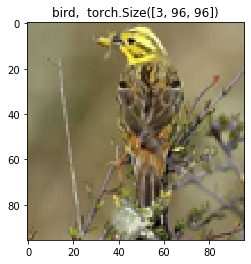

In [3]:
im, lbl = tr[0]
plt.imshow(im.permute(1,2,0))
plt.title(classes[lbl] + f',  {im.shape}');

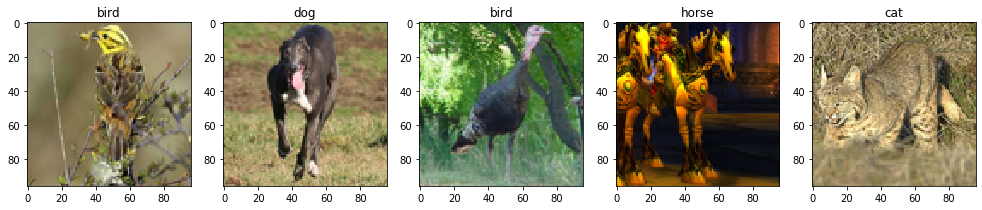

In [4]:
N_IMAGES = 5
fig, axes = plt.subplots(1, N_IMAGES, figsize=(17,4))
for (im, lbl), ax in zip(tr, axes):
    ax.imshow(im.permute(1,2,0))
    ax.set_title(f'{classes[lbl]}')

In [5]:
images = [image for image, label in [tr[i] for i in range(N_IMAGES)]]
images = torch.cat([i.unsqueeze(0) for i in images], dim = 0)
images.shape

torch.Size([5, 3, 96, 96])

## Horizontal Edge Filter

In [6]:
horizontal_filter = [
                     [-.25, -.5, -1, -.5, -.25],
                     [-.5, -1, -3, -1, -.5],
                     [ 0,  0,  0,  0,  0],
                     [ .5, 1,  3,  1, .5],
                     [.25, .5, 1, .5, .25],
                     ]

filter = torch.FloatTensor(horizontal_filter)
filter

tensor([[-0.2500, -0.5000, -1.0000, -0.5000, -0.2500],
        [-0.5000, -1.0000, -3.0000, -1.0000, -0.5000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.5000,  1.0000,  3.0000,  1.0000,  0.5000],
        [ 0.2500,  0.5000,  1.0000,  0.5000,  0.2500]])

### Filter Dimension
- Pytorch Conv2D is performed volume-wise on Batch Input
    - Input is a B3HW tensor, so must be O3hw for the filter.
- The 0-th dimension of the filter means the number of filters.
    - If a filter is 13hw tensor, then its output will have 1 channel as a result; if it is 33hw tensor, the output has 3 channels.

In [7]:
filter = filter.unsqueeze(0).unsqueeze(0)
print(filter.shape)

torch.Size([1, 1, 5, 5])


In [8]:
filter = filter.repeat(1,3,1,1)
filter.shape

torch.Size([1, 3, 5, 5])

In [9]:
filtered_imgs = torch.nn.functional.conv2d(images, filter)
filtered_imgs.shape

torch.Size([5, 1, 92, 92])

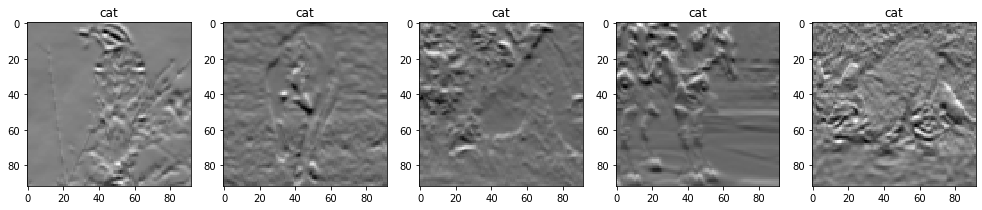

In [10]:
fig, axes = plt.subplots(1, N_IMAGES, figsize=(17,4))
for im, ax in zip(filtered_imgs, axes):
    ax.imshow(im.squeeze(0), cmap='gray')
    ax.set_title(f'{classes[lbl]}')

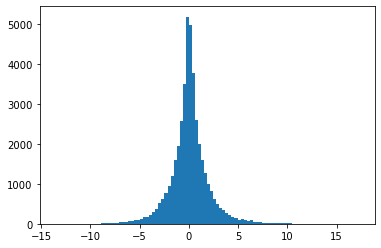

In [11]:
plt.hist(filtered_imgs.view(-1), bins=100);

In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [13]:
for i in range(len(filtered_imgs)):
    filtered_imgs[i] = normalize_image(filtered_imgs[i])

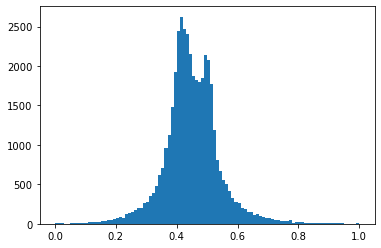

In [14]:
plt.hist(filtered_imgs.view(-1), bins=100);

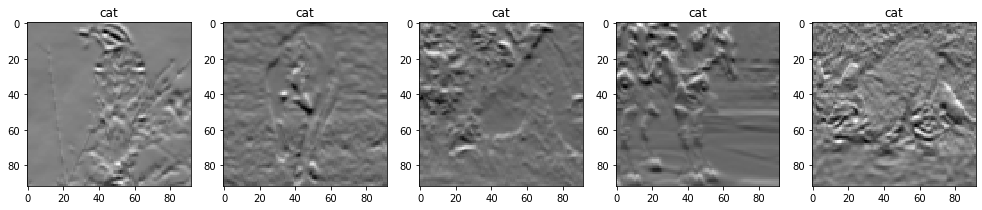

In [15]:
fig, axes = plt.subplots(1, N_IMAGES, figsize=(17,4))
for im, ax in zip(filtered_imgs, axes):
    ax.imshow(im.squeeze(0), cmap='gray')
    ax.set_title(f'{classes[lbl]}')

## Vertical Edge Filter

In [16]:
horizontal_filter = [
                     [-.25, -.5, -1, -.5, -.25],
                     [-.5, -1, -3, -1, -.5],
                     [ 0,  0,  0,  0,  0],
                     [ .5, 1,  3,  1, .5],
                     [.25, .5, 1, .5, .25],
                     ]

filter = torch.FloatTensor(horizontal_filter).T  # transpose of horizontal filter
filter

tensor([[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
        [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
        [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
        [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
        [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]])

In [17]:
filter = filter.unsqueeze(0).unsqueeze(0)
print(filter.shape)

filter = filter.repeat(1,3,1,1)
filter.shape

torch.Size([1, 1, 5, 5])


torch.Size([1, 3, 5, 5])

In [18]:
vfiltered_imgs = torch.nn.functional.conv2d(images, filter)
vfiltered_imgs.shape

torch.Size([5, 1, 92, 92])

In [19]:
for i in range(len(vfiltered_imgs)):
    vfiltered_imgs[i] = normalize_image(vfiltered_imgs[i])

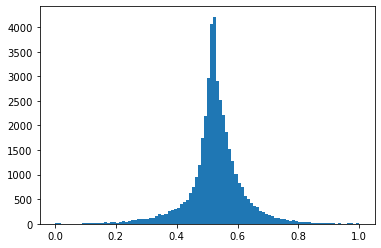

In [20]:
plt.hist(vfiltered_imgs.view(-1), bins=100);

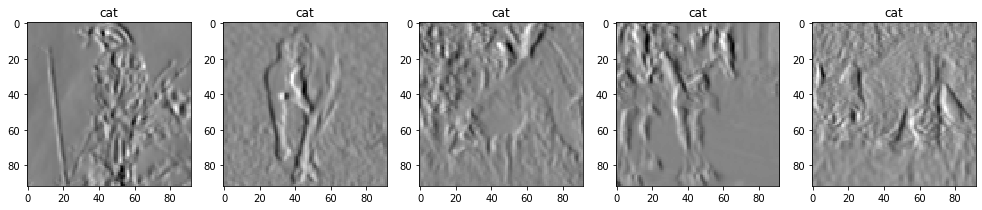

In [21]:
fig, axes = plt.subplots(1, N_IMAGES, figsize=(17,4))
for im, ax in zip(vfiltered_imgs, axes):
    ax.imshow(im.squeeze(0), cmap='gray')
    ax.set_title(f'{classes[lbl]}')

## Edge Strength Map = HE Mag + VE Mag

- Choose sum of absolute values or sqrt of sum of squared (L1 or L2)

In [22]:
edge_mag_imgs = filtered_imgs.abs() + vfiltered_imgs.abs() # L1

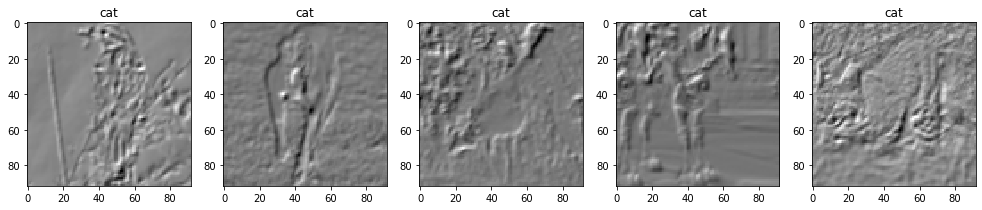

In [23]:
fig, axes = plt.subplots(1, N_IMAGES, figsize=(17,4))
for im, ax in zip(edge_mag_imgs, axes):
    ax.imshow(im.squeeze(0), cmap='gray')
    ax.set_title(f'{classes[lbl]}')

## Canny Edge Filter in OpenCV

- extracts a 1-pixel-width edge
- binary edge pixels (edge or not)
- nonlinear filter: linear edge detection + nonlinear edge thresholding
- opencv or scikit-image
    - working on numpy array, not on pytorch tensor
    - only for gray scale input of type uint8 (normally this is the source type)

In [24]:
import cv2
import numpy as np

In [25]:
np_images = (images.permute(0,2,3,1).numpy() * 255).astype(np.uint8)
np_grays = np.array( [cv2.cvtColor(np_images[i], cv2.COLOR_RGB2GRAY) for i in range(np_images.shape[0])] )
np_grays.shape, type(np_grays), np_grays.dtype

((5, 96, 96), numpy.ndarray, dtype('uint8'))

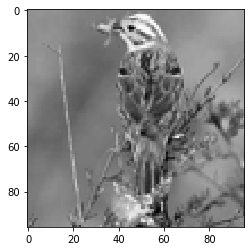

In [26]:
plt.imshow(np_grays[0], cmap='gray')

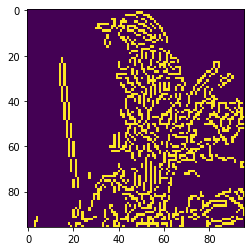

In [27]:
low_th = 100
high_th = 200
edge = cv2.Canny(np_grays[0], low_th, high_th)
plt.imshow(edge)

Wall time: 47.9 ms


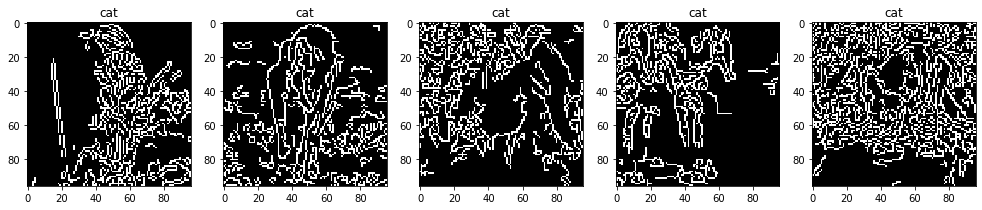

In [28]:
%%time
fig, axes = plt.subplots(1, N_IMAGES, figsize=(17,4))
for im, ax in zip(np_grays, axes):
    ce = cv2.Canny(im, low_th, high_th)
    ax.imshow(ce, cmap='gray')
    ax.set_title(f'{classes[lbl]}')

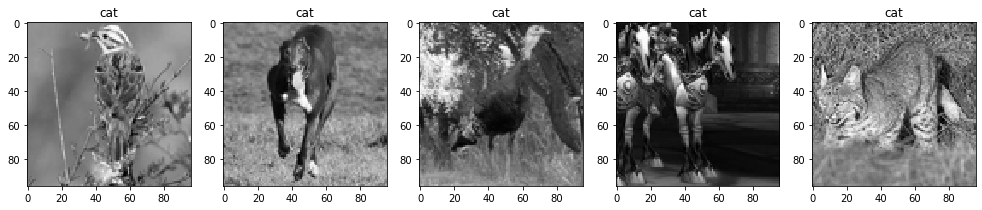

In [29]:
fig, axes = plt.subplots(1, N_IMAGES, figsize=(17,4))
for im, ax in zip(np_grays, axes):
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{classes[lbl]}')

## nn.Conv2d()

- volume-wise convolution
- kernel movels along h,w directions, not C axis

In [31]:
import torch.nn as nn
conv2d = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=5, padding=2, padding_mode='circular')

In [33]:
res = conv2d(images)
res.shape

torch.Size([5, 1, 94, 94])

In [38]:
filter.shape, filter

(torch.Size([1, 3, 5, 5]),
 tensor([[[[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]],
 
          [[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]],
 
          [[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]]]]))

In [37]:
conv2d.weight.shape, conv2d.weight

(torch.Size([1, 3, 5, 5]), Parameter containing:
 tensor([[[[ 0.0396, -0.0421,  0.0553,  0.1060,  0.0807],
           [-0.0394, -0.0966, -0.0977,  0.0362,  0.0217],
           [ 0.0945,  0.0076,  0.0422, -0.0347, -0.0297],
           [ 0.0610, -0.0929, -0.0833, -0.1134, -0.1000],
           [ 0.1053, -0.0084, -0.1110, -0.1012,  0.0642]],
 
          [[ 0.0431,  0.0390, -0.0926,  0.0547, -0.0087],
           [-0.1052,  0.0864,  0.0533, -0.0856,  0.0351],
           [ 0.0429, -0.0248,  0.0023,  0.0290,  0.0034],
           [-0.0067,  0.0814, -0.0554, -0.0116, -0.0703],
           [ 0.0385,  0.0055,  0.1074, -0.0887, -0.0620]],
 
          [[-0.0402, -0.0870, -0.0782, -0.0005,  0.0691],
           [-0.0270, -0.0177,  0.0095, -0.0510,  0.0304],
           [ 0.1117,  0.0763,  0.0580, -0.0067,  0.0475],
           [ 0.1078, -0.1067, -0.0839, -0.0736,  0.1148],
           [-0.0367,  0.0093, -0.0597, -0.0532, -0.0616]]]], requires_grad=True))

In [39]:
conv2d.weight.data = filter
conv2d.weight

Parameter containing:
tensor([[[[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]],

         [[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]],

         [[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]]]], requires_grad=True)

In [40]:
conv2d_imgs = conv2d(images)
conv2d_imgs.shape

torch.Size([5, 1, 94, 94])

In [51]:
for i in range(len(conv2d_imgs)):
    conv2d_imgs[i] = normalize_image(conv2d_imgs[i,0].detach()) # grad info is not required.

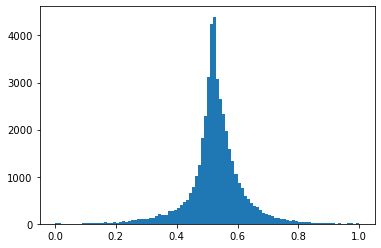

In [53]:
plt.hist(conv2d_imgs.detach().view(-1), bins=100);

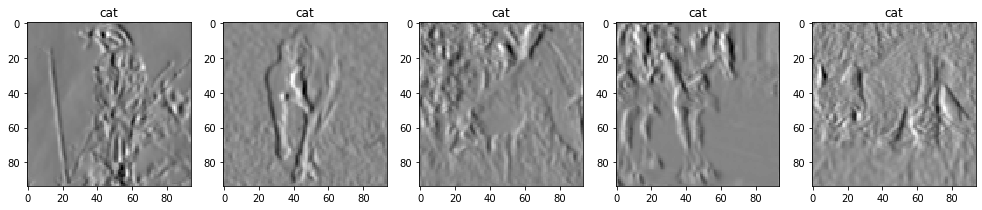

In [54]:
fig, axes = plt.subplots(1, N_IMAGES, figsize=(17,4))
for im, ax in zip(conv2d_imgs, axes):
    ax.imshow(im.detach().squeeze(0), cmap='gray')
    ax.set_title(f'{classes[lbl]}')

## Depth(Channel)-wise convolution

- `groups` controls the connections between inputs and outputs. in_channels and out_channels must both be divisible by groups. For example,
    - At groups=1, all inputs are convolved to all outputs.

    - At groups=2, the operation becomes equivalent to having two conv layers side by side, each seeing half the input channels, and producing half the output channels, and both subsequently concatenated.

    - At `groups=in_channels`, each input channel is convolved with its own set of filters, of size: 
    $
    \left\lfloor\frac{out\_channels}{in\_channels}\right\rfloor
 $

In [128]:
in_channels=3
conv2d_depthwise = nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=5, padding=2, groups=in_channels, bias=False)

In [129]:
conv2d_depthwise.weight.shape

torch.Size([3, 1, 5, 5])

In [130]:
for i in range(3):
    conv2d_depthwise.weight.data[i] = filter[0,0]
conv2d_depthwise.weight

Parameter containing:
tensor([[[[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]]],


        [[[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]]],


        [[[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
          [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
          [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]]]], requires_grad=True)

In [144]:
depthwise_imgs = conv2d_depthwise(images)
depthwise_imgs.shape

torch.Size([5, 3, 96, 96])

### output has 2*in_channels 
- each input channel is fed to two filters, and the results are all stacked to produce the final output
- xyz * abcdef = stack([x*a, x*b, y*c, y*d, z*e, z*f])

In [180]:
conv2d_depthwise2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=5, padding=2, groups=in_channels, bias=True)
conv2d_depthwise2.weight.shape

torch.Size([6, 1, 5, 5])

In [187]:
for i in range(len(conv2d_depthwise2.weight.data)):  # filter set
    conv2d_depthwise2.weight.data[i] = filter[0,0]
#
conv2d_depthwise2.bias.data = torch.zeros(6)

In [188]:
# perform convolution. depth channel [0] and [1] must be the same!
depthwise2_imgs = conv2d_depthwise2(images) # convolve
depthwise2_imgs.shape

torch.Size([5, 6, 96, 96])

In [171]:
conv2d_depthwise2.bias, conv2d_depthwise2.weight

(Parameter containing:
 tensor([0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
 tensor([[[[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]]],
 
 
         [[[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]]],
 
 
         [[[-0.2500, -0.5000,  0.0000,  0.5000,  0.2500],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-1.0000, -3.0000,  0.0000,  3.0000,  1.0000],
           [-0.5000, -1.0000,  0.0000,  1.0000,  0.5000],
           [-0.2500, -0.5000,  0.0000,  0.5000,  0.2500]]],
 
 
         [[[

In [190]:
batch_index = 0
o = depthwise2_imgs[batch_index].detach().numpy()

In [191]:
o.shape

(6, 96, 96)

In [192]:
d = o[0] - o[1]

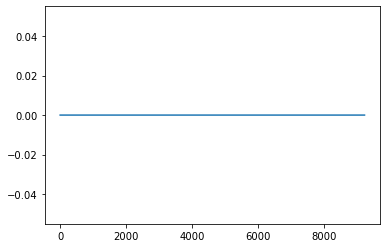

In [193]:
plt.plot(d.flatten())

In [195]:
np.unique(d)

array([0.], dtype=float32)

In [199]:
for i in range(0, 6, 2):
    d = o[i] - o[i+1]
    print(i, ':', d.sum(), np.abs(d).sum())

0 : 0.0 0.0
2 : 0.0 0.0
4 : 0.0 0.0


## Point-wise Convolution

- use `kernel_size=1`

---
## Practicum

### HE Filter by NN
- Design an NN architecture having Conv2D layer that learns the horizontal edge filtering.
- Use STL10 dataset
- Apply HE filter to produce target images.
- Target images are of 1 channel.
- MSELoss or L1Loss may be chosen as the loss function.

### Canny Edge Filter by NN
- Design your own architecture
- You need more than two layers since Canny detector has nonlinearity and threshold.
- An option of the last stage of the network can be:
    - sigmoid for each pixel location so that each pixel value may be limited to [0,1].
    - As the loss function,
        - MSELoss or L1Loss 
        - BCELoss, assuming that the output of each pixel is a probability (Bernoulli distribution)

End.